## @Mattias: This code will produce the correlation plot between theta sweep length and replay diffusivity

Before you start, I assumed you have got the "mental distance from actual position". If not, Here is how I got this info (after I trained the clusterless classifier):

        #calculate the ahead and behind distance between actual position and mental position
        mental_distance_from_actual_position_ahead_behind = get_ahead_behind_distance(
            track_graph, *trajectory_data)

And I saved this result on the disk. 

To get the averaged theta sequence length, you can:
- Step1: extract the perior when animals' speed > a threshold (I used 4cm/s in my analysis)  
- Step2: band-pass filter the LFP to get theta (I used 5-11 Hz) in the extracted periods
- Step3: in each LFP theta cycle, get the sweep amplitude by suctracting the most negative value from the most positive value using "mental_distance_from_actual_position_ahead_behind"
- Step4: Average the amplitudes across all LFP theta cycles.

To get the replay diffusivity , you can:
- Step1: get the ripple time (or MUA time. I used the ripple time, not the MUA time)
- Step2: extract "mental_distance_from_actual_position_ahead_behind" in all ripple events.
- Step3: calculate the diffusivity using the code I provide below.

In the end, for each animal under each running session, let's say Env A in phase 1, I expect you will get 1 value for the mean theta sweep amplitude, 1 value for the replay diffusivity.

### 1, Here is the code to calculate the diffusivity of the replay trejactories in one recording session

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get_steps(Replay_traj, timeb=1):
    '''
    Get the levy exponent for replay trajectory
    Input 
        (dictionary): Replay_traj
        (int): time bin
    Output:
        (numpy array): all_steps for all ripple events
    
    '''
    #initialze an empty numpy array
    all_steps = []

    keys = Replay_traj.keys()
    for key in keys:
        #get the replay trajectory for each ripple events
        ripple_traj = Replay_traj[key]
        traj_step = np.abs(np.diff(ripple_traj[::timeb]))
        #concatenate the steps for all ripple events
        all_steps = np.concatenate((all_steps, traj_step))
    
    return all_steps

#log-log plot of the average step size against time bins
def get_diffusion_exponent(Replay_traj): 
    
    #return plt
    all_timebins = np.arange(1,20,1)
    all_avg_steps = []
    all_std_steps = []
    for timeb in all_timebins:
        all_steps = get_steps(Replay_traj, timeb)
        #get the average step size for each time bin
        avg_step = np.mean(all_steps)
        std_step = np.std(all_steps)
        
        all_avg_steps.append(avg_step)
        all_std_steps.append(std_step)
    #get the slope of the log-log plot
    slope, intercept = np.polyfit(np.log(all_timebins), np.log(all_avg_steps), 1)

    return slope

In [ ]:
#1, Load replay trajectory data
datadir = '*Yourdatafolder*'
replay_traj_filename = '*Yourreplaytrajectoryfile*.pkl' #assume you saved the replay trajectory file as .pkl file
#load the data
with open(os.path.join(datadir, replay_traj_filename), 'rb') as f:
    Replay_traj = pickle.load(f)

#The Replay_traj is a dictionary with ripple event id as keys and replay trajectory as values 

#2, Calculate the diffusivity for each recording session
replay_exponent, replay_intercept = get_diffusion_exponent(Replay_traj, plot=False, get_intercept=True)


### 2, Here is the code to plot the correlation between theta sweep amplitude and replay diffusivity

In [8]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap

In [9]:
#all_sweep_amp_peranimal_persession is a dictionary with animal id as keys and a list of sweep length for each recording session as values
#all_exponent_peranimal_persession is a dictionary with animal id as keys and a list of diffusion exponent for each recording session as values

# load real data: ./sweep_replay_correlation_realdata.pkl
# !!! need to run SeeepAwakeReplayCorrelation.ipynb first to generate the pickle file if not exist
with open("./sweep_replay_correlation_realdata.pkl", "rb") as f:
    (
        animal_names,
        _,
        all_sweep_amp_peranimal_persession,
        _,
        _,
        all_exponent_peranimal_persession,
        _,
    ) = pickle.load(f)

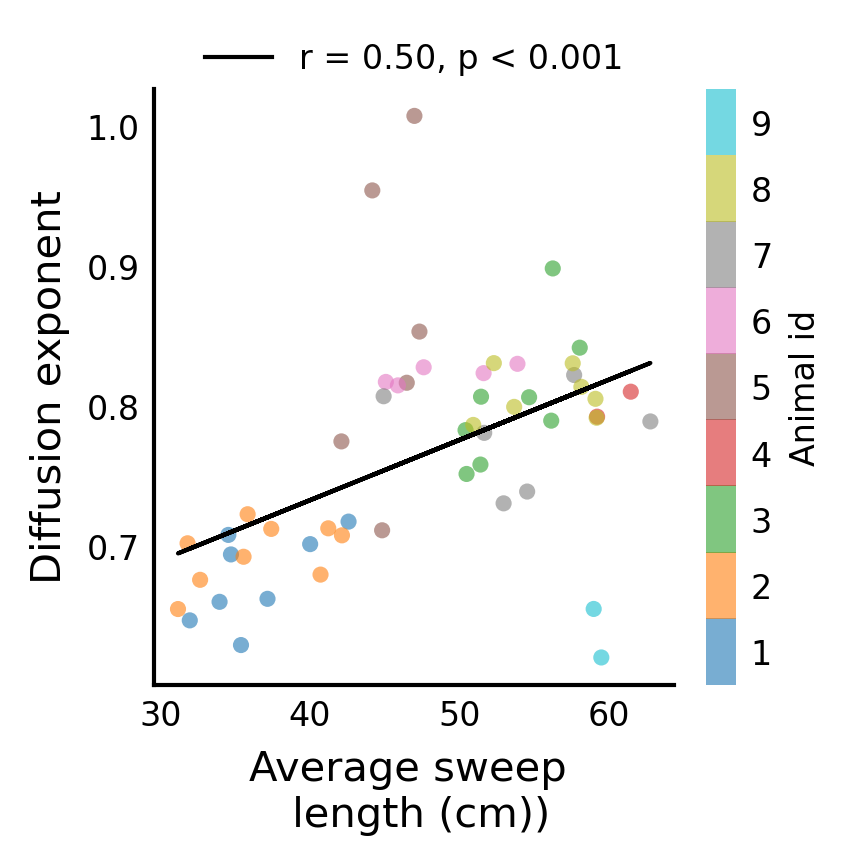

In [11]:
colors = plt.cm.get_cmap("tab10", len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)

plt.figure(figsize=(3, 3), dpi=300)
ticksize = 8
labelsize = 10
ax1 = plt.subplot(111)

#do scatter plot
for name in animal_names:
    plt.scatter(
        np.array(all_sweep_amp_peranimal_persession[name]),
        np.array(all_exponent_peranimal_persession[name]),
        s=15,
        alpha=0.6,
        color=color_dict[name],
        edgecolors="none",
    )

# add linear fit line to the plot using numpy.polyfit
sweep_len_np = np.concatenate(list(all_sweep_amp_peranimal_persession.values()))
exp_np = np.concatenate(list(all_exponent_peranimal_persession.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
# pearson test
corr, p = pearsonr(sweep_len_np, exp_np)

# if p<0.001, then add label as 'r = %.2f, p < 0.001'; else add label as 'r = %.2f, p = %.3f'
if p < 0.001:
    ax1.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p < 0.001" % (corr),
        linewidth=1,
    )
else:
    ax1.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p = %.3f" % (corr, p),
        linewidth=1,
    )

# legend
ax1.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.05))

# add colorbar with alpha 0.8
cmap = ListedColormap(color_dict.values())
# Create a ScalarMappable with the colormap and normalize it
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(color_dict)))
# Set the colorbar properties
cbar = plt.colorbar(sm, ax=ax1, ticks=list(range(len(color_dict))), alpha=0.6)
# Set colorbar ticks by adding 1 to each tick
ticks = list(range(len(color_dict)))
cbar.set_ticks([tick + 0.5 for tick in ticks])
# set tick labels by adding 1 to each tick
cbar.set_ticklabels(list(range(1, len(color_dict) + 1)))
# Set colorbar ticklabels by adding 1 to each tick
# Set colorbar label
cbar.set_label("Animal id", fontsize=ticksize)
# remove the box of the colorbar
cbar.outline.set_visible(False)
# set cbar tick size, # remove the short ticks in cbar
cbar.ax.tick_params(labelsize=ticksize, length=0)

ax1.set_xlabel("Average sweep \n length (cm))", fontsize=labelsize)
ax1.set_ylabel("Diffusion exponent", fontsize=labelsize)

ax1.tick_params(labelsize=ticksize)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
# axis line width 1.0
ax1.spines["bottom"].set_linewidth(1.0)
ax1.spines["left"].set_linewidth(1.0)
# remove the tick bars on the left and bottom
ax1.tick_params(axis="both", which="both", length=0)

plt.tight_layout()
